# Computing the likelihood and posterior for the Brock and Hommes model

In this notebook we use the LikelihoodLoss to estimate the log-likelihood and the posterior of 2 parameters of the BH4 model.

In [1]:
import black_it
import numpy as np
import matplotlib.pyplot as plt

from black_it.calibrator import Calibrator

from black_it.loss_functions.likelihood import LikelihoodLoss
from black_it.samplers.base import BaseSampler

from scipy.special import logsumexp

%load_ext autoreload
%autoreload 2

In [2]:
def BH4(theta, N, seed):
    """
    Model from Brock and Hommes 1998.
    
    Eqs. (36-40) of Dyer et al., Black-box Bayesian inference for economic agent-based models (2022)
    
    Args:
        theta: parameters
        N: length of simulation
        seed: random seed

    Returns:
        simulated series
    """
    np.random.seed(seed=seed)

    R = 1.0
    sigma = 0.04
    
    beta = 120 # suggested values: 10, 120
    g1, b1, b4 = 0., 0., 0.
    g4 = 1.01
    
    g2, b2, g3, b3 = theta[0], theta[1], 0.9, -0.2#theta[2], theta[3]
    # parameter set1: (g2, b2, g3, b3) = (0.9, 0.2, 0.9, −0.2)
    x_lag3 = 0.10
    x_lag2 = 0.10
    x_lag1 = 0.10

    x = np.zeros(N + 2)
    n = np.full(2, 0.50)

    x[0],x[1],x[2] = x_lag1, x_lag2, x_lag3

    g = np.array([g1, g2, g3, g4])
    b = np.array([b1, b2, b3, b4])
    
    for t in range(3, N + 1):
        den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
        
        f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R 
        
        x[t+1] = np.random.normal(f, sigma/R)
        
    return np.atleast_2d(x[2:]).T


Text(0, 0.5, 'y(t)')

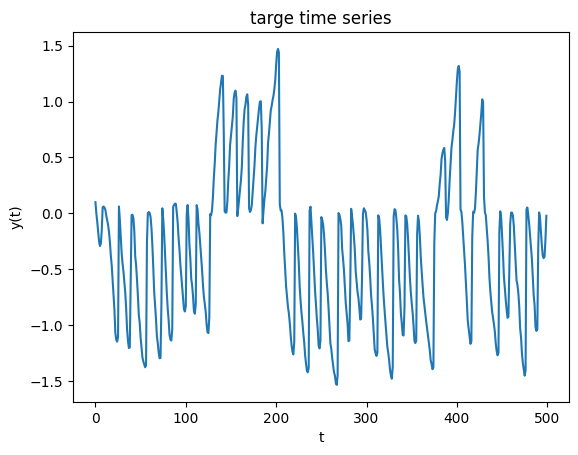

In [3]:
# synthetic target series (parameter set 1 of [Dyer et al. (2022)])
target_series = BH4(theta = [0.9, 0.2], N= 500, seed=0)
plt.plot(target_series)
plt.title("targe time series")
plt.xlabel("t")
plt.ylabel("y(t)")

In [4]:
# Define a space of parameter combinations ("H") to explore
nx, ny = 21, 21
xs = np.linspace(0, 1, nx)
ys = np.linspace(0, 1, ny)

H = []
for x in xs:
    for y in ys:
        H.append([x, y])

H = np.array(H)

441


Text(0, 0.5, 'param 1')

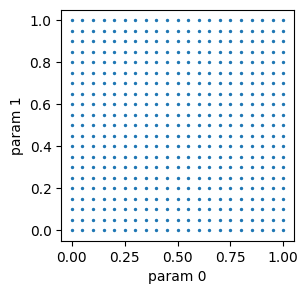

In [5]:
# grid of points we are considering
print(len(H))
plt.figure(figsize = (3, 3))
plt.scatter(H[:, 0], H[:, 1], s = 2.0)
plt.xlabel("param 0")
plt.ylabel("param 1")

In [6]:
# define a "dummy" sampler which simply returns the grid of paramerers to explore
class HSampler(BaseSampler):
        
    def sample_batch(
        self,
        batch_size,
        search_space,
        existing_points,
        existing_losses):

        return H

In [7]:
# initialise dummy sampler and a likelihood loss
dymmy_sampler = HSampler(batch_size = len(H))
loss = LikelihoodLoss(h = 'silverman') # use the Silverman's rule of thumb

In [8]:
# define some bounds and precisions
bounds = [[0.0, 0.0], 
          [1.0, 1.0]]

precisions = [0.001, 0.001]

In [9]:
# initialise a calibrator object
cal = Calibrator(
    samplers=[dymmy_sampler],
    loss_function=loss,
    model=BH4,
    parameters_bounds=bounds,
    sim_length = 1000,   # simulation length for each parameter combination
    ensemble_size=1,     # number of repetitions for each parameter combination
    parameters_precision=precisions,
    real_data=target_series,
    random_state=1,
)


***
Number of free params:       2.
Explorable param space size: 1002001.
***

Selecting 4 processes for the parallel evaluation of the model


/Users/aldoglielmo/DRTA_code/black-it/black_it/calibrator.py:99: RuntimeWarning: The length of real time series is different from the simulation length, got 500 and 1000. This may or may not be a problem depending on the loss function used.
  warnings.warn(


In [10]:
# calibrate for a single epoch over the grid
params, losses = cal.calibrate(1)



BATCH NUMBER:   1
PARAMS SAMPLED: 0

METHOD: HSampler


/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_23898/476028437.py:39: RuntimeWarning: overflow encountered in exp
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_23898/476028437.py:41: RuntimeWarning: overflow encountered in exp
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_23898/476028437.py:41: RuntimeWarning: invalid value encountered in divide
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_23898/476028437.py:39: RuntimeWarning: overflow encountered in exp
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_23898/476028437.py:41: RuntimeWarning: overflow encountered in exp
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_23898/476028437.py:41: RuntimeWarning: invalid value encountered in divide
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_23898/476028437.py:39: RuntimeWarning: overflow encountered in exp
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_23898/476028437.py:41: RuntimeWarning: over

/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_23898/476028437.py:39: RuntimeWarning: overflow encountered in exp
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_23898/476028437.py:41: RuntimeWarning: overflow encountered in exp
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_23898/476028437.py:41: RuntimeWarning: invalid value encountered in multiply
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_23898/476028437.py:39: RuntimeWarning: overflow encountered in exp
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_23898/476028437.py:41: RuntimeWarning: overflow encountered in exp
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_23898/476028437.py:41: RuntimeWarning: invalid value encountered in multiply
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_23898/476028437.py:39: RuntimeWarning: overflow encountered in exp
/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_23898/476028437.py:41: RuntimeWarning: 

/var/folders/t5/yx84b1sd52lblk0kjl01g2y00000gn/T/ipykernel_23898/476028437.py:41: RuntimeWarning: invalid value encountered in divide


----> sim exec elapsed time: 12.6s
---->   min loss new params: nan
---->   avg loss new params: nan
----> avg loss exist params: nan
---->         curr min loss: nan
====>    total elapsed time: 12.6s


In [11]:
# substitute NaN values with maximum loss values
max_loss = np.nanmax(losses)
losses[np.isnan(losses)] = max_loss

In [12]:
# compute posterior probability
log_likelihood = -losses

prior = np.ones(len(H)) * 1.0/len(H)

log_posterior = log_likelihood + np.log(prior) - logsumexp(log_likelihood + np.log(prior))

posterior = np.exp(log_posterior)

In [13]:
# check normalisation of the posterior
sum(posterior)

1.0000000000000187

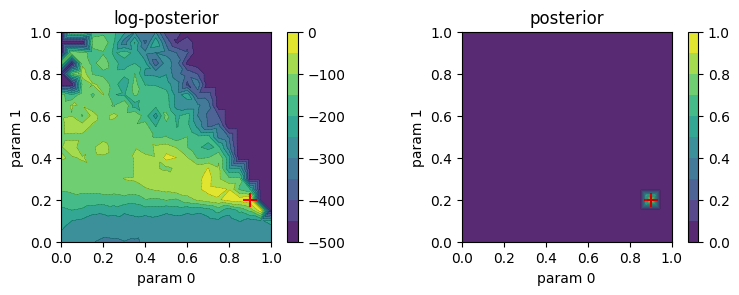

In [14]:
# plot the log posterior over a 2D grid

levels = 10
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (8, 3))
ax = axes[0]

ax.set_aspect('equal')
tcf = ax.tricontourf(params[:, 0], params[:, 1], log_posterior, levels=levels, alpha=0.9 )
fig.colorbar(tcf)
ax.tricontour(params[:, 0], params[:, 1], log_posterior, levels=levels, alpha=0.8, colors='k', linewidths = 0.2)
ax.set_title('log-posterior')
ax.scatter(params[0, 0], params[0, 1], color = 'r', marker = '+', s = 100)
ax.set_xlabel("param 0")
ax.set_ylabel("param 1")

ax = axes[1]
ax.set_aspect('equal')
tcf = ax.tricontourf(params[:, 0], params[:, 1], posterior, levels=levels, alpha=0.9 )
fig.colorbar(tcf)
ax.tricontour(params[:, 0], params[:, 1], posterior, levels=levels, alpha=0.8, colors='k', linewidths = 0.2)
ax.set_title('posterior')
ax.scatter(params[0, 0], params[0, 1], color = 'r', marker = '+', s = 100)
ax.set_xlabel("param 0")
ax.set_ylabel("param 1")

plt.tight_layout()

MAP parameters:  [0.9 0.2]


Text(0, 0.5, 'y(t)')

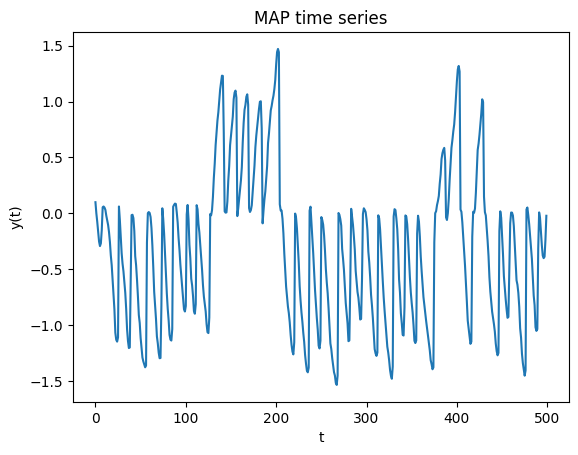

In [15]:
# maximum-a-posterior (MAP) parametes and MAP time series
print("MAP parameters: ", params[0])
best_series = BH4(theta = params[0], N= 500, seed=0)
plt.plot(best_series);
plt.title("MAP time series")
plt.xlabel("t")
plt.ylabel("y(t)")

In [16]:
# obtain empirical marginal distributions over single parameters
p0s = list(set(params[:, 0]))
p0s.sort()
p1s = list(set(params[:, 1]))
p1s.sort()

posterior_p0s = []
for p0 in p0s:
    idx = params[:, 0] == p0
    l = np.sum(posterior[idx])
    posterior_p0s.append(l)

posterior_p0s = np.array(posterior_p0s)

posterior_p1s = []
for p1 in p1s:
    idx = params[:, 1] == p1
    l = np.sum(posterior[idx])
    posterior_p1s.append(l)

posterior_p1s = np.array(posterior_p1s)

Text(0, 0.5, 'marginal posterior')

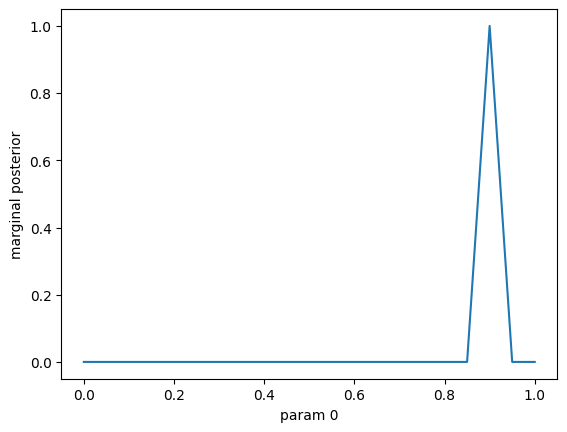

In [17]:
plt.plot(p0s, posterior_p0s)
plt.xlabel('param 0')
plt.ylabel('marginal posterior')

Text(0, 0.5, 'marginal posterior')

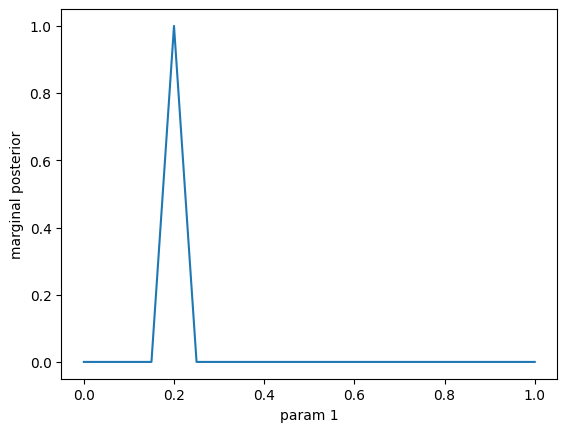

In [18]:
plt.plot(p1s, posterior_p1s)
plt.xlabel('param 1')
plt.ylabel('marginal posterior')